In [1]:
import psycopg2
import pandas as pd
from getpass import getpass
from sklearn.metrics import brier_score_loss, roc_auc_score, log_loss, roc_curve
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
import pymc3 as pm
import numpy as np
from scipy.optimize import curve_fit
import seaborn as sns
import theano
import matplotlib.pyplot as plt
import joblib
%matplotlib inline

np.random.seed(13)
pd.options.display.max_columns = 999

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
c:\python37\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
user = getpass()
password = getpass()
ip = getpass()
port = getpass()
dbname = getpass()

········
········
········
········
········


In [3]:
db_connection_string = 'postgresql://{}:{}@{}:{}/{}'

with psycopg2.connect(db_connection_string.format(user,
                                                  password,
                                                  ip,
                                                  port,
                                                  dbname)) as con:
    cursor = con.cursor()

    sql = """SELECT game_evals.game_link,
                    chess_games.player_elo,
                    half_move,
                    result,
                    evaluation
             from game_evals
             tablesample bernoulli(1.5) repeatable(13)
             JOIN chess_games on chess_games.game_link = game_evals.game_link
             WHERE evaluation not in (-9999, 9999)
             and chess_games.player_elo > 2200
             ;
             """
    cursor.execute(sql)
    colnames = [desc.name for desc in cursor.description]
    results = cursor.fetchall()

In [4]:
df = pd.DataFrame.from_records(results, columns=colnames)

In [5]:
df.head()

,game_link,player_elo,half_move,result,evaluation
0,https://lichess.org/gwk278au,2880.0,1,1/2-1/2,0.13
1,https://lichess.org/gwk278au,2880.0,25,1/2-1/2,0.60
2,https://lichess.org/gwk278au,2880.0,47,1/2-1/2,-0.11
3,https://lichess.org/gwk278au,2880.0,48,1/2-1/2,0.55
4,https://lichess.org/1vPqh41u,2882.0,43,0-1,0.28


In [6]:
df.shape

(6334, 5)

In [7]:
df['result_points'] = (df['result'] == '1-0') + (df['result'] == '1/2-1/2') * 0.5
df['evaluation_binned'] = (df['evaluation'] / 3).round(decimals=0) * 3

In [8]:
df.head(100)

,game_link,player_elo,half_move,result,evaluation,result_points,evaluation_binned
0,https://lichess.org/gwk278au,2880.0,1,1/2-1/2,0.13,0.5,0.0
1,https://lichess.org/gwk278au,2880.0,25,1/2-1/2,0.60,0.5,0.0
2,https://lichess.org/gwk278au,2880.0,47,1/2-1/2,-0.11,0.5,-0.0
3,https://lichess.org/gwk278au,2880.0,48,1/2-1/2,0.55,0.5,0.0
4,https://lichess.org/1vPqh41u,2882.0,43,0-1,0.28,0.0,0.0
...,...,...,...,...,...,...,...
95,https://lichess.org/ZVqgnSn1,2799.0,52,0-1,-1.62,0.0,-3.0
96,https://lichess.org/D8DAxDKJ,2823.0,13,0-1,0.42,0.0,0.0
97,https://lichess.org/D8DAxDKJ,2823.0,76,0-1,-14.15,0.0,-15.0
98,https://lichess.org/D8DAxDKJ,2823.0,79,0-1,-24.95,0.0,-24.0


In [9]:
df['evaluation_binned'].max(), df['evaluation_binned'].min()

(78.0, -147.0)

In [10]:
grouped = df.groupby(['evaluation_binned'], as_index=False).agg({'result_points': 'mean'})

In [11]:
x_train, x_test, y_train, y_test = train_test_split(df['evaluation'], df['result_points'], test_size=0.2, random_state=13)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=13)

x_train.shape, x_val.shape, x_test.shape

((3800,), (1267,), (1267,))

Pre-outlier removal size: (3800,)
Post-outlier removal size: (2925,)


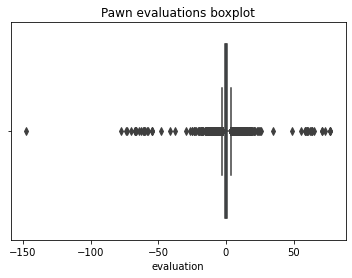

In [12]:
sns.boxplot(x_train)
plt.title('Pawn evaluations boxplot')

p25 = np.percentile(x_train, 25)
p75 = np.percentile(x_train, 75)
iqr = p75 - p25

print(f'Pre-outlier removal size: {x_train.shape}')
y_train = y_train[x_train > p25 - 1.5 * iqr]
y_train = y_train[x_train < p75 + 1.5 * iqr]
x_train = x_train[x_train > p25 - 1.5 * iqr]
x_train = x_train[x_train < p75 + 1.5 * iqr]
print(f'Post-outlier removal size: {x_train.shape}')

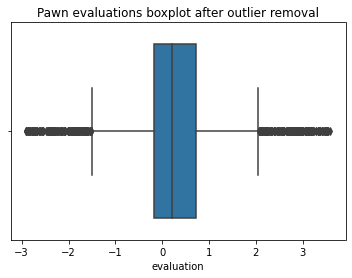

In [13]:
plt.title('Pawn evaluations boxplot after outlier removal')
sns.boxplot(x_train);

In [14]:
def logifunc(x, x0, k, A, B, offset):
    return A / (B + np.exp(-k * (x - x0))) + offset

x0: 0.56, k: 0.85, A: 0.75, B: 1.21, offset: 0.23


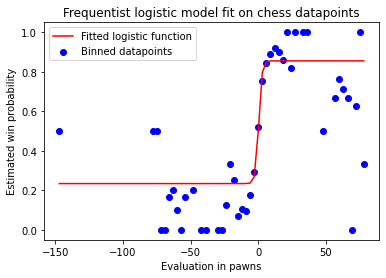

In [15]:
# reference: https://chesscomputer.tumblr.com/post/98632536555/using-the-stockfish-position-evaluation-score-to
popt, pcov = curve_fit(logifunc, x_train, y_train, p0=[0, 0.5, 1, 1, 0], maxfev=10000)

plt.scatter(grouped['evaluation_binned'],
            grouped['result_points'],
            color='b',
            label='Binned datapoints')
plt.plot(grouped['evaluation_binned'],
         logifunc(grouped['evaluation_binned'], *popt),
         'r-',
         label='Fitted logistic function')
plt.xlabel('Evaluation in pawns')
plt.ylabel('Estimated win probability')
plt.title('Frequentist logistic model fit on chess datapoints')
plt.legend()

print('x0: {:.2f}, k: {:.2f}, A: {:.2f}, B: {:.2f}, offset: {:.2f}'.format(*popt))

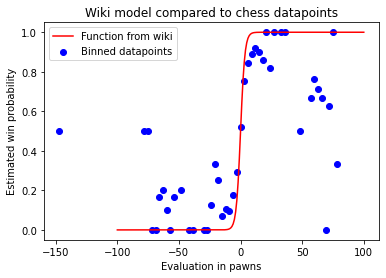

In [16]:
plt.scatter(grouped['evaluation_binned'], grouped['result_points'], color='b', label='Binned datapoints')
# reference: https://www.chessprogramming.org/Pawn_Advantage,_Win_Percentage,_and_Elo
plt.plot(range(-100, 101),
         [1 / (1 + 10 ** (-p / 4)) for p in range(-100, 101)],
         color='r',
         label='Function from wiki')
plt.xlabel('Evaluation in pawns')
plt.ylabel('Estimated win probability')
plt.title('Wiki model compared to chess datapoints')
plt.legend(loc='best');

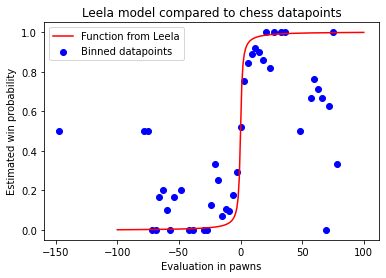

In [17]:
plt.scatter(grouped['evaluation_binned'], grouped['result_points'], color='b', label='Binned datapoints')
# reference: Leela Chess Zero
plt.plot(range(-100, 101),
         [((np.arctan(p / (0.01 * 111.714640912)) / 1.5620688421) + 1) / 2
          for p in range(-100, 101)],
         color='r',
         label='Function from Leela')
plt.xlabel('Evaluation in pawns')
plt.ylabel('Estimated win probability')
plt.title('Leela model compared to chess datapoints')
plt.legend(loc='best');

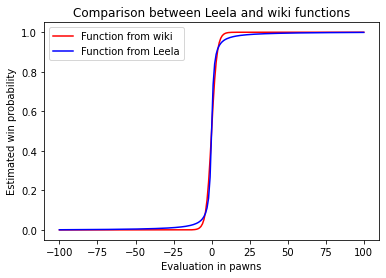

In [18]:
plt.plot(range(-100, 101),
         [1 / (1 + 10 ** (-p / 4)) for p in range(-100, 101)],
         color='r',
         label='Function from wiki')
plt.plot(range(-100, 101),
         [((np.arctan(p / (0.01 * 111.714640912)) / 1.5620688421) + 1) / 2
          for p in range(-100, 101)],
         color='b',
         label='Function from Leela')
plt.xlabel('Evaluation in pawns')
plt.ylabel('Estimated win probability')
plt.title('Comparison between Leela and wiki functions')
plt.legend(loc='best');

In [19]:
x_shared = theano.shared(x_train.values)
y_shared = theano.shared(y_train.values)

In [20]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    x_0 = pm.Normal('x_0', mu=0, sigma=10)
    k = pm.Normal('k', mu=0, sigma=10)
    A = 1
    B = 1
    offset = 0
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Expected value of outcome
    mu = A / (B + pm.math.exp(-k * (x_shared - x_0))) + offset

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=y_shared)

In [21]:
map_estimate = pm.find_MAP(model=basic_model)
map_estimate

{'x_0': array(-0.0647556),
 'k': array(0.45838714),
 'sigma_log__': array(-0.78847835),
 'sigma': array(0.45453591)}

In [22]:
with basic_model:
    trace = pm.sample(1000, tune=4000, random_seed=13)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, k, x_0]


Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 75 seconds.


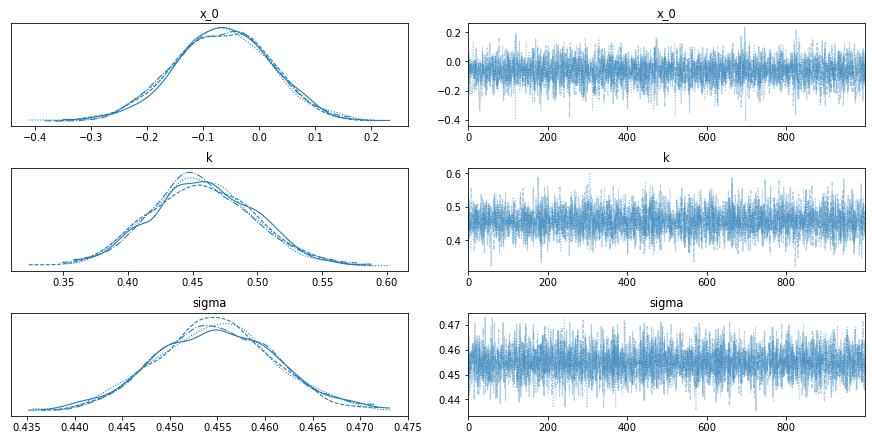

In [23]:
with basic_model:
    pm.traceplot(trace);

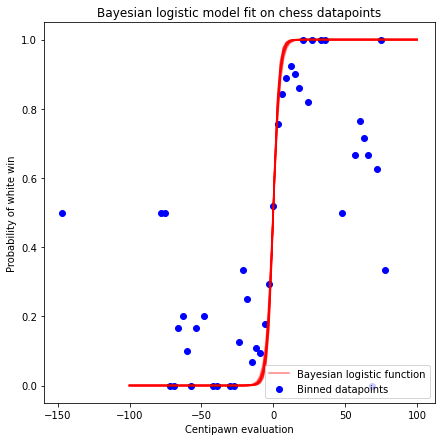

In [24]:
samples = trace.points()
plt.figure(figsize=(7, 7))

for i in range(100):
    sample = next(samples)
    plt.plot(np.linspace(-100, 100, 100),
             logifunc(np.linspace(-100, 100, 100),
                      sample['x_0'],
                      sample['k'],
                      1,
                      1,
                      0,
                      ),
             color='r',
             alpha=0.5 if i == 0 else 0.05,
             label='Bayesian logistic function' if i == 0 else None,
             )
plt.scatter(grouped['evaluation_binned'],
            grouped['result_points'],
            color='b',
            label='Binned datapoints')
plt.xlabel('Centipawn evaluation')
plt.ylabel('Probability of white win')
plt.title('Bayesian logistic model fit on chess datapoints')
plt.legend(loc='lower right');

In [25]:
def leelafunc(p):
    return ((np.arctan(p / (0.01 * 111.714640912)) / 1.5620688421) + 1) / 2

In [26]:
lr = LogisticRegressionCV(Cs=[10 ** (x / 10) for x in range(-80, 80, 5)],
                          l1_ratios=[x / 10 for x in range(11)],
                          n_jobs=-1,
                          random_state=13,
                          penalty='elasticnet',
                          solver='saga',
                          )
lr.fit(x_train.values.reshape(-1, 1), y_train.astype(str))
y_pred_lr = pd.Series(lr.predict_proba(x_val.values.reshape(-1, 1)) @ np.array([0, 0.5, 1]))

c:\python37\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


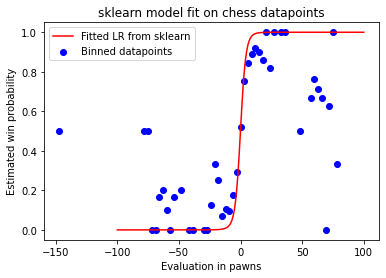

In [27]:
plt.scatter(grouped['evaluation_binned'], grouped['result_points'], color='b', label='Binned datapoints')
plt.plot(range(-100, 101),
         [lr.predict_proba(np.array(p).reshape(-1, 1)) @ np.array([0, 0.5, 1])
          for p in range(-100, 101)],
         color='r',
         label='Fitted LR from sklearn')
plt.xlabel('Evaluation in pawns')
plt.ylabel('Estimated win probability')
plt.title('sklearn model fit on chess datapoints')
plt.legend(loc='best');

In [28]:
x_shared.set_value(x_val.values)
y_shared.set_value(y_val.values)

with basic_model:
    post_pred = pm.sample_posterior_predictive(trace, samples=4000, random_seed=13)

In [29]:
y_pred_bayes = pd.Series(post_pred['Y_obs'].mean(axis=0))
y_pred_leela = leelafunc(x_val)

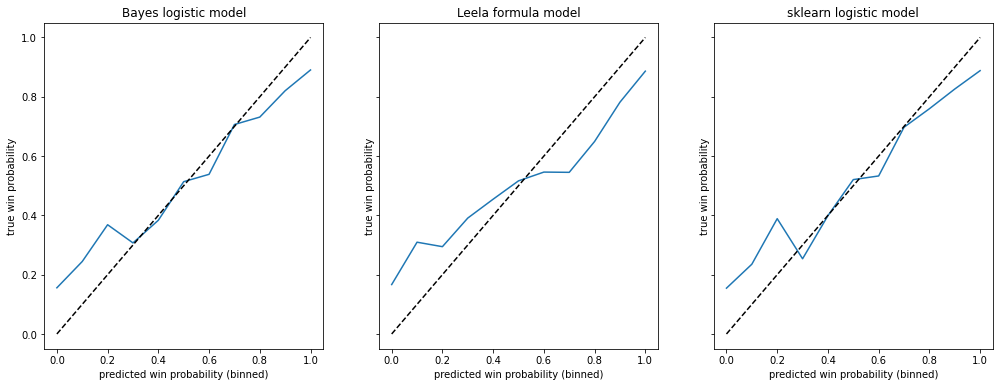

In [30]:
# calibration plots

predictions = pd.concat([y_val.reset_index(drop=True),
                         y_pred_bayes.reset_index(drop=True),
                         y_pred_leela.reset_index(drop=True),
                         y_pred_lr.reset_index(drop=True),
                         ],
                        axis=1)

predictions.columns = ['true', 'pred_bayes', 'pred_leela', 'pred_lr']
predictions['binned_bayes'] = predictions['pred_bayes'].round(decimals=1)
predictions['binned_leela'] = predictions['pred_leela'].round(decimals=1)
predictions['binned_lr'] = predictions['pred_lr'].round(decimals=1)

calibration_bayes = predictions.groupby(['binned_bayes'], as_index=False).agg({'true': 'mean'})
calibration_leela = predictions.groupby(['binned_leela'], as_index=False).agg({'true': 'mean'})
calibration_lr = predictions.groupby(['binned_lr'], as_index=False).agg({'true': 'mean'})

fig, axs = plt.subplots(figsize=(17, 6), ncols=3, sharey=True)

axs[0].plot(calibration_bayes['binned_bayes'], calibration_bayes['true'])
axs[0].plot([0, 1], [0, 1], 'k--')
axs[0].set_xlabel('predicted win probability (binned)')
axs[0].set_ylabel('true win probability')
axs[0].set_title('Bayes logistic model')

axs[1].plot(calibration_leela['binned_leela'], calibration_leela['true'])
axs[1].plot([0, 1], [0, 1], 'k--')
axs[1].set_xlabel('predicted win probability (binned)')
axs[1].set_ylabel('true win probability')
axs[1].set_title('Leela formula model')

axs[2].plot(calibration_lr['binned_lr'], calibration_lr['true'])
axs[2].plot([0, 1], [0, 1], 'k--')
axs[2].set_xlabel('predicted win probability (binned)')
axs[2].set_ylabel('true win probability')
axs[2].set_title('sklearn logistic model');

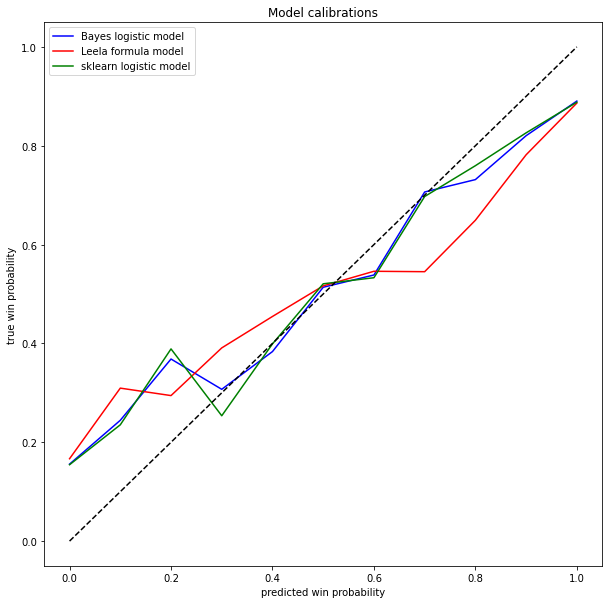

In [31]:
plt.figure(figsize=(10, 10))

plt.plot(calibration_bayes['binned_bayes'], calibration_bayes['true'], color='b', label='Bayes logistic model')
plt.plot(calibration_leela['binned_leela'], calibration_leela['true'], color='r', label='Leela formula model')
plt.plot(calibration_lr['binned_lr'], calibration_lr['true'], color='g', label='sklearn logistic model')

plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('predicted win probability')
plt.ylabel('true win probability')
plt.title('Model calibrations')
plt.legend(loc='best');

In [32]:
for name, pred in {'bayes': y_pred_bayes, 'leela': y_pred_leela, 'LR': y_pred_lr}.items():
    print(name)
    brier = brier_score_loss(y_val == 1, pred.clip(0, 1))
    auc = roc_auc_score(y_val == 1, pred.clip(0, 1))
    log = log_loss(y_val == 1, pred.clip(0, 1))
    print(f'Brier score: {brier:.4f},\nAUC: {auc:.4f},\nLog loss: {log:.4f}\n')

bayes
Brier score: 0.2270,
AUC: 0.6934,
Log loss: 0.7889

leela
Brier score: 0.2370,
AUC: 0.6935,
Log loss: 0.6989

LR
Brier score: 0.2270,
AUC: 0.6935,
Log loss: 0.7341



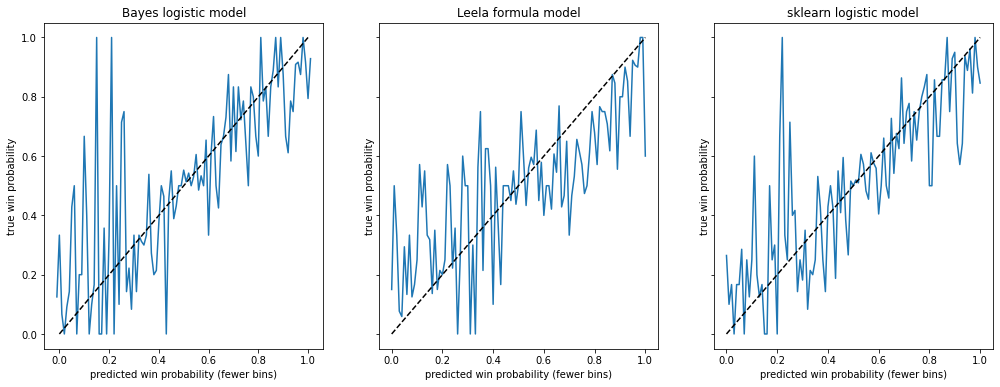

In [33]:
predictions['binned_bayes'] = predictions['pred_bayes'].round(decimals=2)
predictions['binned_leela'] = predictions['pred_leela'].round(decimals=2)
predictions['binned_lr'] = predictions['pred_lr'].round(decimals=2)
calibration_bayes = predictions.groupby(['binned_bayes'], as_index=False).agg({'true': 'mean'})
calibration_leela = predictions.groupby(['binned_leela'], as_index=False).agg({'true': 'mean'})
calibration_lr = predictions.groupby(['binned_lr'], as_index=False).agg({'true': 'mean'})

fig, axs = plt.subplots(figsize=(17, 6), ncols=3, sharey=True)

axs[0].plot(calibration_bayes['binned_bayes'], calibration_bayes['true'])
axs[0].plot([0, 1], [0, 1], 'k--')
axs[0].set_xlabel('predicted win probability (fewer bins)')
axs[0].set_ylabel('true win probability')
axs[0].set_title('Bayes logistic model')

axs[1].plot(calibration_leela['binned_leela'], calibration_leela['true'])
axs[1].plot([0, 1], [0, 1], 'k--')
axs[1].set_xlabel('predicted win probability (fewer bins)')
axs[1].set_ylabel('true win probability')
axs[1].set_title('Leela formula model')

axs[2].plot(calibration_lr['binned_lr'], calibration_lr['true'])
axs[2].plot([0, 1], [0, 1], 'k--')
axs[2].set_xlabel('predicted win probability (fewer bins)')
axs[2].set_ylabel('true win probability')
axs[2].set_title('sklearn logistic model');

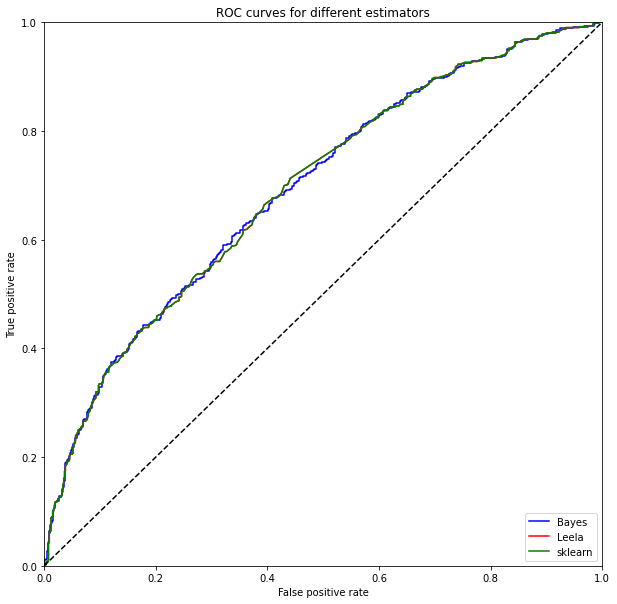

In [34]:
plt.figure(figsize=(10, 10))

fpr, tpr, _ = roc_curve(y_val == 1, y_pred_bayes)
plt.plot(fpr, tpr, color='b', label='Bayes')

fpr, tpr, _ = roc_curve(y_val == 1, y_pred_leela)
plt.plot(fpr, tpr, color='r', label='Leela')

fpr, tpr, _ = roc_curve(y_val == 1, y_pred_lr)
plt.plot(fpr, tpr, color='g', label='sklearn')

plt.plot([0, 1], [0, 1], 'k--')

plt.title('ROC curves for different estimators')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(loc='lower right');

In [35]:
predictions.head()

,true,pred_bayes,pred_leela,pred_lr,binned_bayes,binned_leela,binned_lr
0,0.0,0.515752,0.531416,0.520818,0.52,0.53,0.52
1,0.0,0.458050,0.374972,0.456241,0.46,0.37,0.46
2,0.0,1.000588,0.997066,1.000000,1.00,1.00,1.00
3,1.0,0.500956,0.500000,0.508333,0.50,0.50,0.51
4,0.0,0.550200,0.615107,0.555827,0.55,0.62,0.56


In [36]:
# disagreeing by more than 0.1 probability
predictions[(predictions['pred_bayes'] - predictions['pred_leela']).abs() > 0.1]

,true,pred_bayes,pred_leela,pred_lr,binned_bayes,binned_leela,binned_lr
7,0.0,0.629602,0.745986,0.628133,0.63,0.75,0.63
10,1.0,0.743014,0.860221,0.749198,0.74,0.86,0.75
11,0.0,0.279088,0.147019,0.276336,0.28,0.15,0.28
13,1.0,0.721433,0.840419,0.720220,0.72,0.84,0.72
18,0.0,0.365085,0.217322,0.358416,0.37,0.22,0.36
...,...,...,...,...,...,...,...
1254,1.0,0.588313,0.693167,0.594683,0.59,0.69,0.59
1255,0.0,0.337956,0.191374,0.333010,0.34,0.19,0.33
1256,1.0,0.622590,0.733704,0.619606,0.62,0.73,0.62
1259,1.0,0.599615,0.718801,0.609922,0.60,0.72,0.61


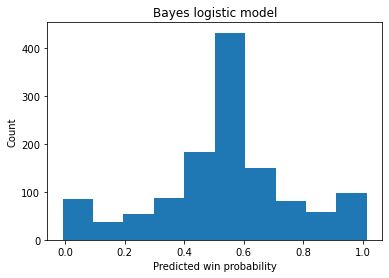

In [37]:
plt.hist(predictions['pred_bayes'])
plt.title('Bayes logistic model')
plt.xlabel('Predicted win probability')
plt.ylabel('Count');

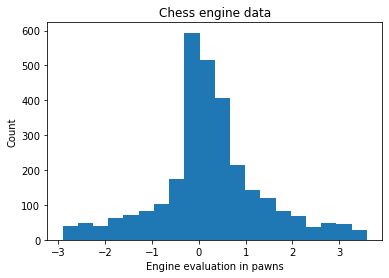

In [38]:
plt.hist(x_train, bins=20)
plt.title('Chess engine data')
plt.xlabel('Engine evaluation in pawns')
plt.ylabel('Count');

In [39]:
# how does the bayesian model perform out of sample?

x_shared.set_value(x_test.values)
y_shared.set_value(y_test.values)

with basic_model:
    post_pred = pm.sample_posterior_predictive(trace, samples=4000, random_seed=1313)

y_pred = pd.Series(post_pred['Y_obs'].mean(axis=0))

In [40]:
brier = brier_score_loss(y_test == 1, y_pred.clip(0, 1))
auc = roc_auc_score(y_test == 1, y_pred.clip(0, 1))
log = log_loss(y_test == 1, y_pred.clip(0, 1))
print(f'Brier score: {brier:.4f},\nAUC: {auc:.4f},\nLog loss: {log:.4f}')

Brier score: 0.2129,
AUC: 0.7349,
Log loss: 0.7453


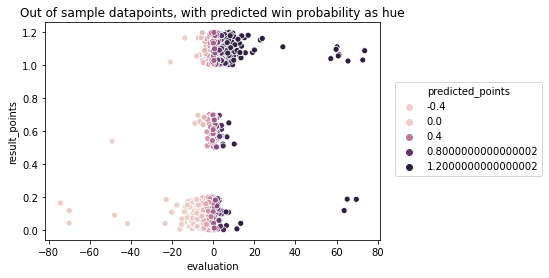

In [41]:
test_results = pd.concat([x_test.reset_index(drop=True),
                          y_test.reset_index(drop=True),
                          y_pred.reset_index(drop=True)],
                         axis=1)
test_results.columns = ['evaluation', 'result_points', 'predicted_points']

test_results['binned_predictions'] = test_results['predicted_points'].round(decimals=1)
test_calibration = test_results.groupby(['binned_predictions'], as_index=False).agg({'result_points': 'mean'})

# add jitter for visibility
test_results['result_points'] += np.random.random(size=test_results['result_points'].shape) / 5

sns.scatterplot(x='evaluation', y='result_points', hue='predicted_points', data=test_results)
plt.legend(bbox_to_anchor=[1.5, 0.75])
plt.title('Out of sample datapoints, with predicted win probability as hue');

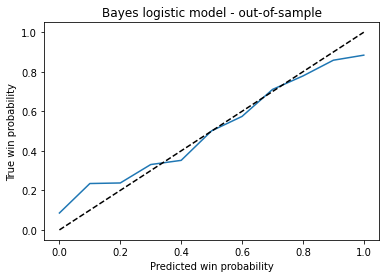

In [42]:
plt.plot(test_calibration['binned_predictions'], test_calibration['result_points'])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Predicted win probability')
plt.ylabel('True win probability')
plt.title('Bayes logistic model - out-of-sample');

In [43]:
test_calibration

,binned_predictions,result_points
0,0.0,0.085526
1,0.1,0.234694
2,0.2,0.237500
3,0.3,0.330769
4,0.4,0.351852
5,0.5,0.501182
6,0.6,0.574153
7,0.7,0.710526
8,0.8,0.778689
9,0.9,0.858491


In [44]:
pm.save_trace(trace, directory='bayes_wp_model.trace', overwrite=True)

'bayes_wp_model.trace'

In [45]:
joblib.dump(lr, 'lr_wp_model.joblib')

['lr_wp_model.joblib']